In [1]:
import os
import numpy as np
import dask
from dask.distributed import Client, progress

In [2]:
os.environ['GPAW_SETUP_PATH'] = os.path.expanduser('~/resources')

In [3]:
from ase.build import bulk
from gpaw import GPAW, PW

In [4]:
client = Client(threads_per_worker=1, n_workers=9)
client

Client Scheduler: tcp://127.0.0.1:37161 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 9 Memory: 2.15 GB


In [5]:
a0 = 3.52 / np.sqrt(2)
c0 = np.sqrt(8 / 3.0) * a0

In [6]:
eps = 0.01
lattice_parameter = []
for a in a0 * np.linspace(1 - eps, 1 + eps, 3):
    for c in c0 * np.linspace(1 - eps, 1 + eps, 3):
        lattice_parameter.append([a, c])

In [7]:
def calc_eng_pot(a, c):
    ni = bulk('Ni', 'hcp', a=a, c=c)
    job_name = 'Ni_' + str(np.round(a,3)).replace('.', '_') + '___' + str(np.round(c,3)).replace('.', '_') + '.out'
    calc = GPAW(mode=PW(200),xc='LDA',txt=job_name)
    return calc.get_potential_energy(ni)

In [8]:
calc_eng_pot_delayed = dask.delayed(calc_eng_pot)

In [9]:
energies_delayed = []
for a, c in lattice_parameter:
    energies_delayed.append(calc_eng_pot_delayed(a=a, c=c))

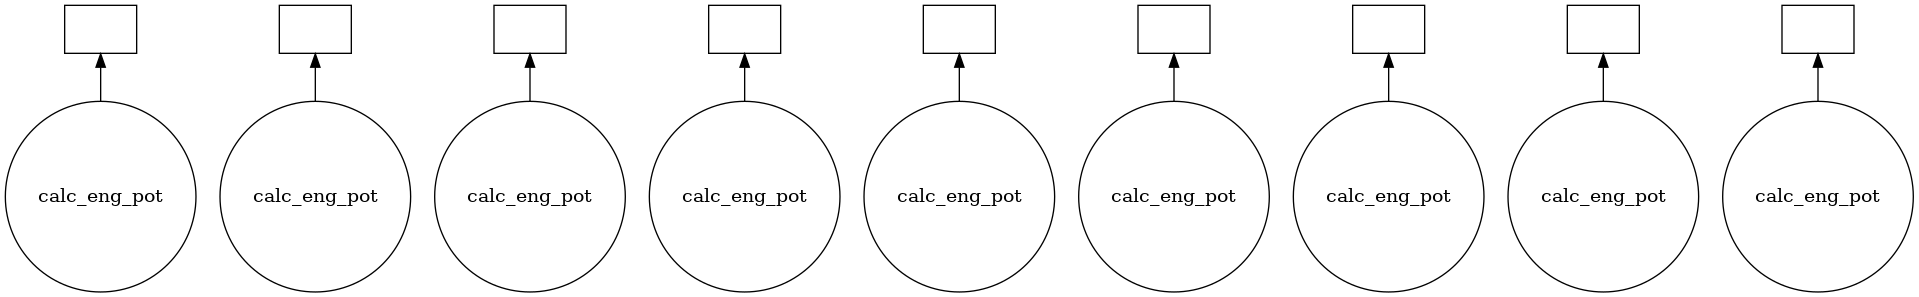

In [10]:
dask.visualize(energies_delayed)

In [11]:
energies = dask.compute(energies_delayed)

In [12]:
a_lst, c_lst = zip(*lattice_parameter)
a = np.array(list(a_lst))
c = np.array(list(c_lst))

In [13]:
functions = np.array([a**0, a, c, a**2, a * c, c**2])
p = np.linalg.lstsq(functions.T, energies[0], rcond=-1)[0]

In [14]:
p0 = p[0]
p1 = p[1:3]
p2 = np.array([(2 * p[3], p[4]),
               (p[4], 2 * p[5])])
a0, c0 = np.linalg.solve(p2.T, -p1)

In [15]:
a0, c0

(3.644965951954405, -0.04841928727660758)